In [ ]:
# %pip install tiktoken --user
%pip install hf_xet --user 


In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer,
    pipeline
)
from datasets import Dataset, DatasetDict, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
# import os
import os, sys, time, subprocess, random
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------
# 1. Load and Prepare Dataset
# -----------------------

# Load the ShonaSenti corpus (from Part B)
shona_senti_path = "data/shona_senti.csv"
df_shona = pd.read_csv(shona_senti_path)

print(f"Dataset shape: {df_shona.shape}")
print(f"Columns: {df_shona.columns.tolist()}")
print("Label distribution:")
print(df_shona['label'].value_counts().sort_index())

# Check label format and convert if necessary
if df_shona['label'].dtype == 'object':
    # Convert string labels to numerical
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df_shona['labels'] = df_shona['label'].map(label_mapping)
    print("Converted string labels to numerical")

# Split into train and validation sets
train_df, val_df = train_test_split(
    df_shona, 
    test_size=0.2, 
    random_state=42,
    stratify=df_shona['labels']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Optional: Augment with lexicon data if 
lexicon_aug_path = "expanded_lexicon_v4.csv"
if os.path.exists(lexicon_aug_path):
    df_lexicon_aug = pd.read_csv(lexicon_aug_path)
    print(f"Lexicon augmentation samples: {len(df_lexicon_aug)}")
    train_df = pd.concat([train_df, df_lexicon_aug], ignore_index=True)
    print(f"Training samples after augmentation: {len(train_df)}")

# Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print("Dataset preparation complete!")

Dataset shape: (15959, 3)
Columns: ['text', 'label', 'text_en']
Label distribution:
label
negative    7820
neutral     3395
positive    4744
Name: count, dtype: int64
Converted string labels to numerical
Training samples: 12767
Validation samples: 3192
Dataset preparation complete!


In [3]:
# -----------------------
# Initialize Models and Tokenizers
# -----------------------

import sys
import subprocess

def pipi(*pkgs): 
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])

# Ensure SentencePiece is present (AfriBERTa/XLM-R need it)
try:
    import sentencepiece  # noqa
except ImportError:
    pipi("sentencepiece>=0.1.99")

from transformers import AutoTokenizer, AutoModelForSequenceClassification

ID2LABEL = {0: "negative", 1: "neutral", 2: "positive"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

MODELS_CONFIG = {
    "afroxlmr": {
        "name": "Davlan/afro-xlmr-base",
        "display_name": "AfroXLMR",
        "use_fast": True,
    },
    "afriberta": {
        "name": "castorini/afriberta_base",
        "fallback": "castorini/afriberta_base", 
        "display_name": "AfriBERTa",
        "use_fast": False,
    },
}

tokenizers, models = {}, {}

for key, cfg in MODELS_CONFIG.items():
    name = cfg["name"]
    use_fast = cfg.get("use_fast", True)
    disp = cfg["display_name"]

    print(f"\nLoading {disp} ({name}) …")
    try:
        tokenizers[key] = AutoTokenizer.from_pretrained(name, use_fast=use_fast, resume_download=True)
        models[key] = AutoModelForSequenceClassification.from_pretrained(
            name, 
            num_labels=3, 
            id2label=ID2LABEL, 
            label2id=LABEL2ID, 
            resume_download=True
        )
        print(f"  ✓ Loaded {disp}")
    except Exception as e:
        # Fallback to base for AfriBERTa if large has issues
        if key == "afriberta" and "fallback" in cfg:
            fb = cfg["fallback"]
            print(f"  ! {disp} large failed ({type(e).__name__}: {e}) → falling back to {fb}")
            tokenizers[key] = AutoTokenizer.from_pretrained(fb, use_fast=False, resume_download=True)
            models[key] = AutoModelForSequenceClassification.from_pretrained(
                fb, 
                num_labels=3, 
                id2label=ID2LABEL, 
                label2id=LABEL2ID, 
                resume_download=True
            )
            print(f"  ✓ Loaded {disp} (base)")
        else:
            print(f"  ✗ Failed to load {disp}: {e}")
            raise

print(f"\nSuccessfully loaded {len(models)} model(s).")


Loading AfroXLMR (Davlan/afro-xlmr-base) …


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Loaded AfroXLMR

Loading AfriBERTa (castorini/afriberta_base) …


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Loaded AfriBERTa

Successfully loaded 2 model(s).


In [4]:
# %pip install hf_xet --user
# -----------------------
# 3. Tokenization Function
# -----------------------


def tokenize_function(examples, tokenizer_key):
    """Tokenize the text data and preserve labels"""
    tokenizer = tokenizers[tokenizer_key]
    tokenized = tokenizer(
        examples['text'], 
        padding=True, 
        truncation=True, 
        max_length=256,
        return_tensors=None  # Let Trainer handle tensor conversion
    )
    # Preserve the labels column for training
    tokenized['labels'] = [
        LABEL2ID[l] if isinstance(l, str) else int(l)
        for l in examples['label']
    ]
    return tokenized

# Tokenize datasets for each model
tokenized_datasets = {}

for model_key in MODELS_CONFIG.keys():
    print(f"Tokenizing data for {MODELS_CONFIG[model_key]['display_name']}...")
    
    tokenized_datasets[model_key] = dataset.map(
        lambda examples: tokenize_function(examples, model_key),
        batched=True,
        remove_columns=['text','label']  # Only remove text, keep labels
    )

print("Tokenization complete!")


Tokenizing data for AfroXLMR...


Map: 100%|██████████| 3192/3192 [00:00<00:00, 14282.03 examples/s]


Tokenizing data for AfriBERTa...


Map: 100%|██████████| 3192/3192 [00:00<00:00, 4978.11 examples/s]

Tokenization complete!


In [ ]:
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers>=4.30.0", "accelerate>=0.20.0"])

In [5]:
# -----------------------
# 4. Training Setup (fixed)
# -----------------------

print("\n4. Setting up training...")

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch

# Custom Trainer class to handle potential issues with loss computation
class FixedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation that ensures labels are properly handled.
        """
        if "labels" in inputs:
            labels = inputs["labels"]
        else:
            labels = None
        
        # Forward pass
        outputs = model(**inputs)
        
        if labels is not None and "loss" not in outputs:
            # Manually compute loss if model didn't return it
            logits = outputs.get("logits")
            if logits is not None:
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
                return (loss, outputs) if return_outputs else loss
        
        # Use default behavior if loss is available
        return super().compute_loss(model, inputs, return_outputs, num_items_in_batch)

model_key = "afroxlmr"  # or "afriberta"

if model_key not in models:
    raise ValueError(f"Model key '{model_key}' not found. Available: {list(models.keys())}")

print(f"Setting up training for {model_key}...")
# Use eval every epoch so we can track best model by f1_macro
training_args = TrainingArguments(
output_dir=f"./model_results/{model_key}",
    eval_strategy="steps",           # ← Evaluate every X steps instead of every epoch
    eval_steps=200,                  # ← Evaluate every 200 steps
    save_strategy="steps",
    save_steps=200,
    save_total_limit=1,
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # ↑ Increase batch size if you have GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=1,              # ↓ Reduce epochs
    max_steps=250,                  # ← Train for fixed steps, not full epochs
    dataloader_num_workers=4,        # ← Parallel data loading
    dataloader_pin_memory=True,      # ← Faster data transfer to GPU
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
    logging_steps=50,
)

def compute_metrics(eval_pred):
    # eval_pred is (logits, labels) or EvalPrediction(logits=..., label_ids=...)
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):  # sometimes tuple(logits)
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

print("Training setup completed!")



4. Setting up training...
Setting up training for afroxlmr...
Training setup completed!


In [6]:
# -----------------------
# 5. Train Individual Models (Fixed)
# -----------------------

print("\n5. Training individual models...")

# Updated custom trainer with correct method signature
class FixedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        
        # Debug: Print what we're getting
        print(f"Input keys: {list(inputs.keys())}")
        if labels is not None:
            print(f"Labels shape: {labels.shape if hasattr(labels, 'shape') else type(labels)}")
        else:
            print("Labels is None - checking for alternative key names...")
            for key in inputs.keys():
                if 'label' in key.lower():
                    print(f"Found potential label key: {key}")
                    labels = inputs[key]
                    break
        
        # If still no labels, cannot compute loss
        if labels is None:
            raise ValueError(f"No labels found in inputs. Available keys: {list(inputs.keys())}")
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Manually compute loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainers = {}
model_predictions = {}

for model_key in MODELS_CONFIG.keys():
    print(f"\n--- Training {MODELS_CONFIG[model_key]['display_name']} ---")
    
    # Update output directories for each model
    model_training_args = TrainingArguments(
        **{**training_args.to_dict(), 
           'output_dir': f"./results/{model_key}",
           }
    )
    
    # Use FixedTrainer instead of regular Trainer
    trainer = FixedTrainer(
        model=models[model_key],
        args=model_training_args,
        train_dataset=tokenized_datasets[model_key]['train'],
        eval_dataset=tokenized_datasets[model_key]['validation'],
        tokenizer=tokenizers[model_key],
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_result = trainer.train()
    
    # Save trainer and model
    trainers[model_key] = trainer
    
    # Evaluate on validation set
    print(f"Evaluating {MODELS_CONFIG[model_key]['display_name']}...")
    eval_results = trainer.evaluate()
    print(f"{MODELS_CONFIG[model_key]['display_name']} Validation Results:")
    for key, value in eval_results.items():
        print(f"  {key}: {value:.4f}")
    
    # Get predictions for ensemble
    predictions = trainer.predict(tokenized_datasets[model_key]['validation'])
    model_predictions[model_key] = predictions

print("Individual model training complete!")


5. Training individual models...

--- Training AfroXLMR ---


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:2108: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
C:\Users\smadu\AppData\Local\Temp\ipykernel_31260\413893018.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FixedTrainer.__init__`. Use `processing_class` instead.
  trainer = FixedTrainer(
c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
200,1.016800,1.023466,0.505326,0.261349,0.361080


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:2108: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
C:\Users\smadu\AppData\Local\Temp\ipykernel_31260\413893018.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FixedTrainer.__init__`. Use `processing_class` instead.
  trainer = FixedTrainer(
c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
200,1.004100,0.999357,0.510338,0.305637,0.397608


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([16])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


Evaluating AfriBERTa...


c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

In [7]:
# -----------------------
# 6. Ensemble Learning
# -----------------------

print("\n6. Implementing ensemble learning...")

# Get prediction probabilities from both models
afroxlmr_probs = torch.softmax(torch.tensor(model_predictions['afroxlmr'].predictions), dim=1).numpy()
afriberta_probs = torch.softmax(torch.tensor(model_predictions['afriberta'].predictions), dim=1).numpy()

# Simple averaging ensemble
ensemble_probs = (afroxlmr_probs + afriberta_probs) / 2
ensemble_predictions = np.argmax(ensemble_probs, axis=1)
true_labels = model_predictions['afroxlmr'].label_ids

# Evaluate ensemble
ensemble_accuracy = accuracy_score(true_labels, ensemble_predictions)
ensemble_f1_macro = f1_score(true_labels, ensemble_predictions, average='macro')
ensemble_f1_weighted = f1_score(true_labels, ensemble_predictions, average='weighted')

print("Ensemble Results:")
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  F1 Macro: {ensemble_f1_macro:.4f}")
print(f"  F1 Weighted: {ensemble_f1_weighted:.4f}")

# Compare with individual models
print("\nModel Comparison:")
models_comparison = []
for model_key in MODELS_CONFIG.keys():
    eval_results = trainers[model_key].evaluate()
    models_comparison.append({
        'Model': MODELS_CONFIG[model_key]['display_name'],
        'Accuracy': eval_results['eval_accuracy'],
        'F1_Macro': eval_results['eval_f1_macro'],
        'F1_Weighted': eval_results['eval_f1_weighted']
    })

models_comparison.append({
    'Model': 'Ensemble (Average)',
    'Accuracy': ensemble_accuracy,
    'F1_Macro': ensemble_f1_macro,
    'F1_Weighted': ensemble_f1_weighted
})

comparison_df = pd.DataFrame(models_comparison)
print(comparison_df.round(4))


6. Implementing ensemble learning...
Ensemble Results:
  Accuracy: 0.5122
  F1 Macro: 0.2824
  F1 Weighted: 0.3803

Model Comparison:


c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])


Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shape: torch.Size([32])
Input keys: ['input_ids', 'attention_mask', 'labels']
Labels shap

Device set to use cpu



7. Applying Explainable AI techniques...

XAI Analysis on Sample Texts:

--- Sample 1 ---


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



AfroXLMR Prediction for: 'This is absolutely wonderful and amazing!'
  negative: 0.3634
  neutral: 0.2530
  positive: 0.3836


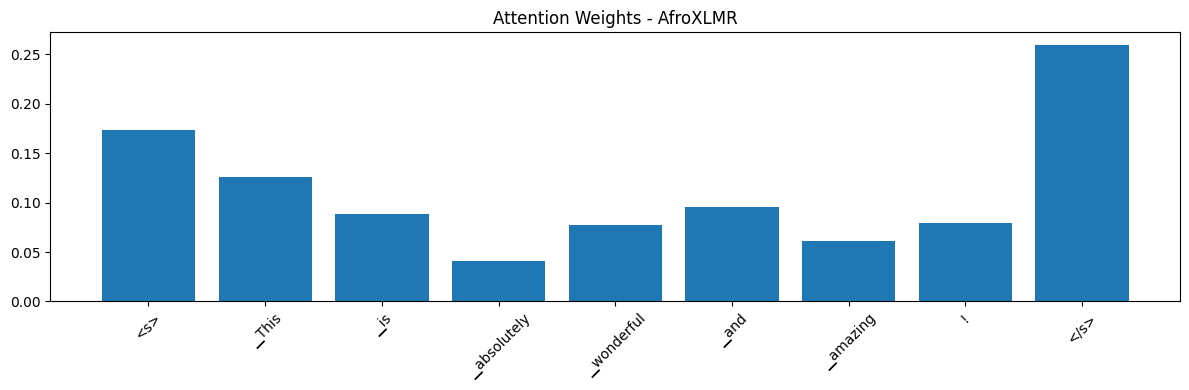

Device set to use cpu
C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



AfriBERTa Prediction for: 'This is absolutely wonderful and amazing!'
  negative: 0.4691
  neutral: 0.1720
  positive: 0.3589


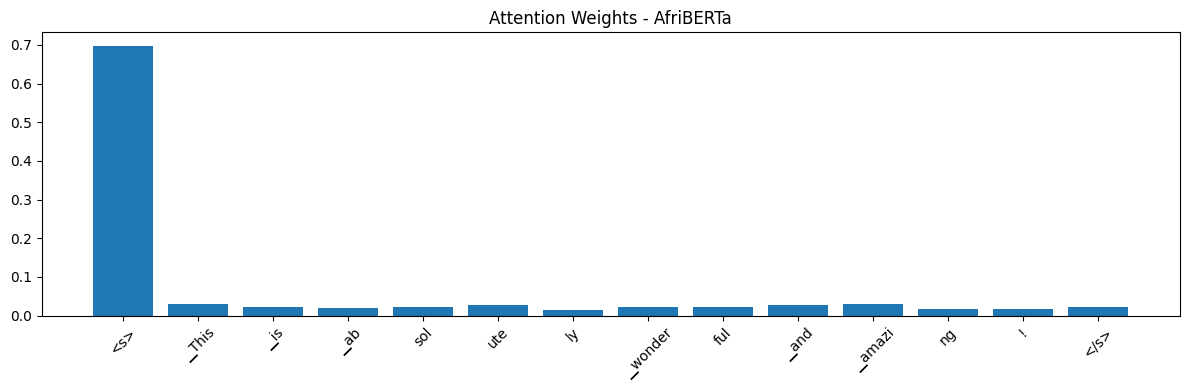

Device set to use cpu



--- Sample 2 ---

AfroXLMR Prediction for: 'I hate this terrible experience'
  negative: 0.3784
  neutral: 0.2365
  positive: 0.3851


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


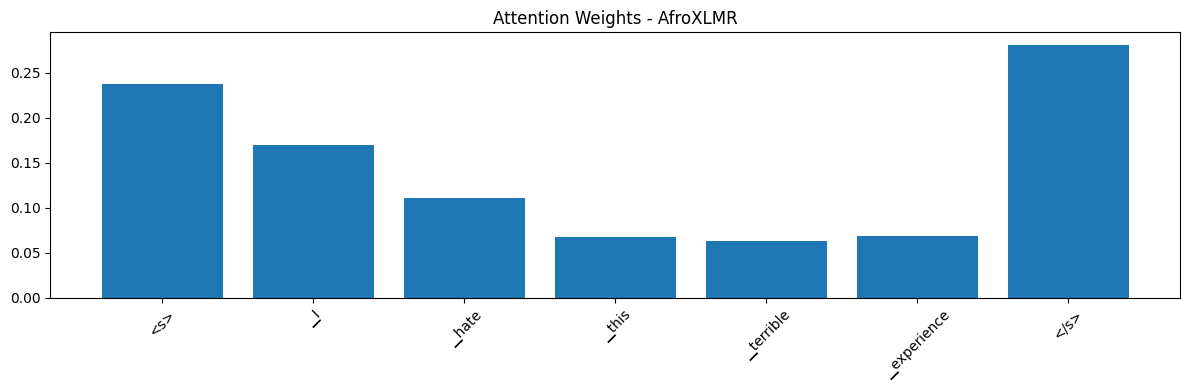

Device set to use cpu



AfriBERTa Prediction for: 'I hate this terrible experience'
  negative: 0.4457
  neutral: 0.2430
  positive: 0.3113


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


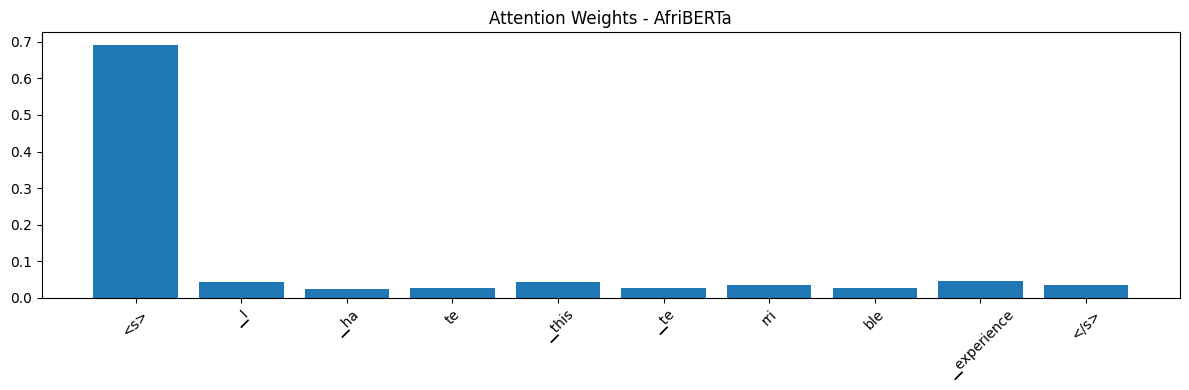

Device set to use cpu



--- Sample 3 ---

AfroXLMR Prediction for: 'The weather is okay today'
  negative: 0.3889
  neutral: 0.2415
  positive: 0.3696


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


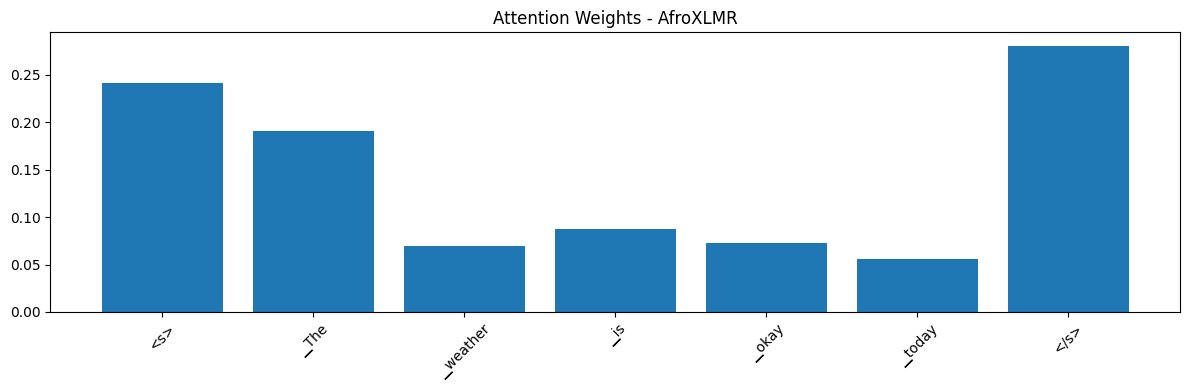

Device set to use cpu



AfriBERTa Prediction for: 'The weather is okay today'
  negative: 0.3762
  neutral: 0.3269
  positive: 0.2969


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


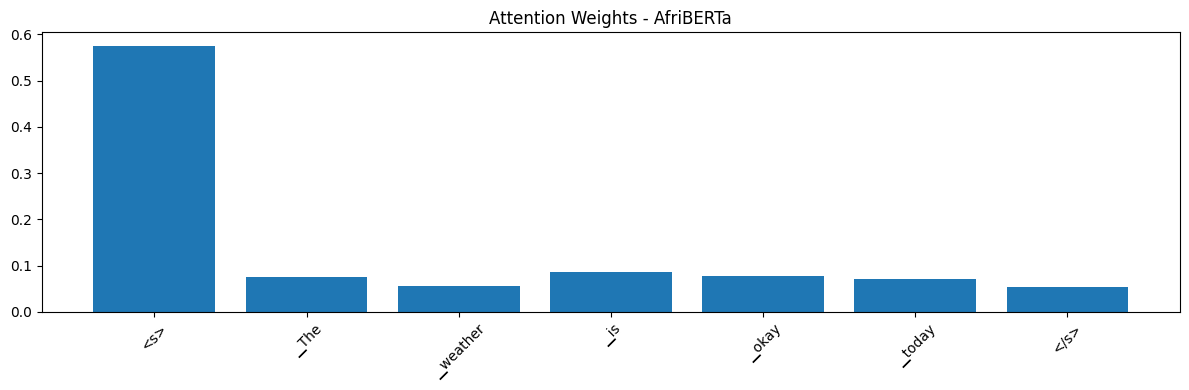

In [8]:

# -----------------------
# 7. Explainable AI (XAI) - Attention Visualization
# -----------------------

print("\n7. Applying Explainable AI techniques...")

def visualize_attention(text, model, tokenizer, model_name):
    """Visualize attention for a given text"""
    # Create a pipeline for the model
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        return_all_scores=True
    )
    
    # Get prediction
    results = classifier(text)
    
    print(f"\n{model_name} Prediction for: '{text}'")
    for result in results[0]:
        print(f"  {result['label']}: {result['score']:.4f}")
    
    # For attention visualization, we need to manually extract attention
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    
    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention weights from the last layer
    attention = outputs.attentions[-1]  # Last layer
    attention = attention.mean(dim=1)   # Average over attention heads
    
    # Visualize attention
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    attention_weights = attention[0].mean(dim=0).detach().numpy()  # Average over layers
    
    # Plot attention visualization
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), attention_weights[:len(tokens)])
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.title(f"Attention Weights - {model_name}")
    plt.tight_layout()
    plt.show()
    
    return attention_weights

# Test XAI on sample texts
sample_texts = [
    "This is absolutely wonderful and amazing!",  # Should be positive
    "I hate this terrible experience",           # Should be negative  
    "The weather is okay today"                  # Should be neutral
]

print("\nXAI Analysis on Sample Texts:")
for i, text in enumerate(sample_texts, 1):
    print(f"\n--- Sample {i} ---")
    for model_key in MODELS_CONFIG.keys():
        try:
            _ = visualize_attention(
                text, 
                models[model_key], 
                tokenizers[model_key],
                MODELS_CONFIG[model_key]['display_name']
            )
        except Exception as e:
            print(f"Error in XAI for {MODELS_CONFIG[model_key]['display_name']}: {e}")



8. Generating detailed performance analysis...


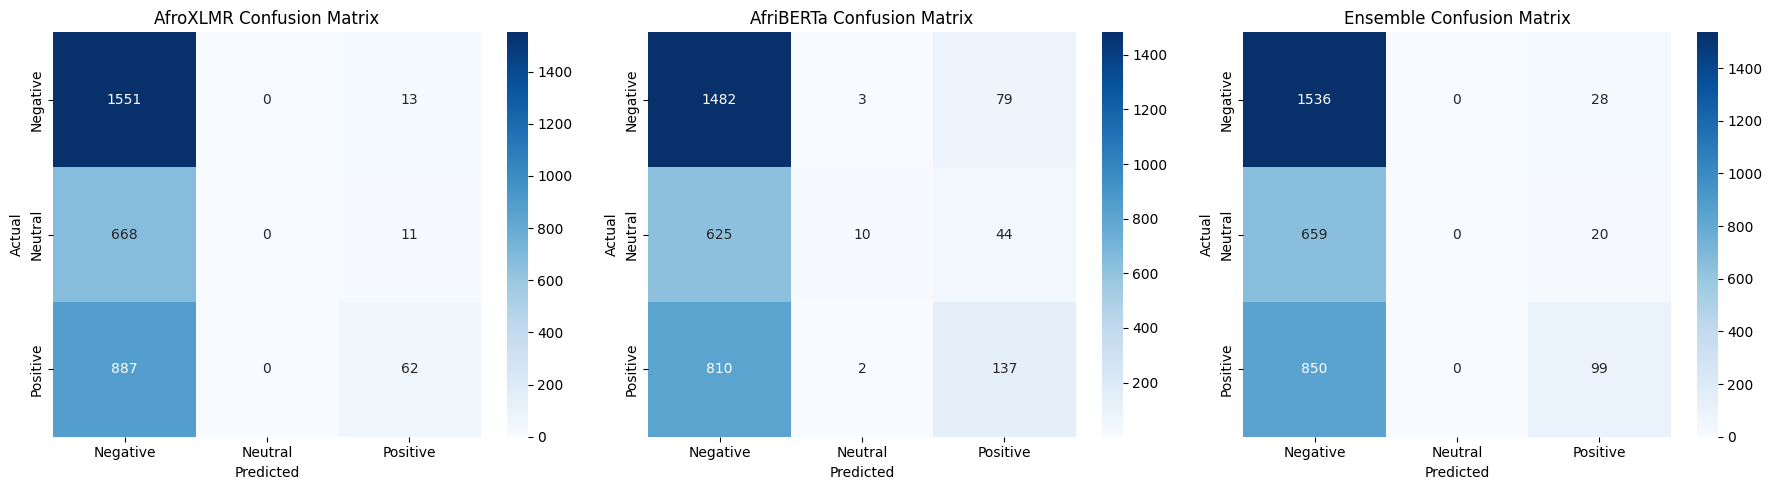


Detailed Classification Reports:

AfroXLMR:
              precision    recall  f1-score   support

    Negative       0.50      0.99      0.66      1564
     Neutral       0.00      0.00      0.00       679
    Positive       0.72      0.07      0.12       949

    accuracy                           0.51      3192
   macro avg       0.41      0.35      0.26      3192
weighted avg       0.46      0.51      0.36      3192


AfriBERTa:
              precision    recall  f1-score   support

    Negative       0.51      0.95      0.66      1564
     Neutral       0.67      0.01      0.03       679
    Positive       0.53      0.14      0.23       949

    accuracy                           0.51      3192
   macro avg       0.57      0.37      0.31      3192
weighted avg       0.55      0.51      0.40      3192


Ensemble:
              precision    recall  f1-score   support

    Negative       0.50      0.98      0.67      1564
     Neutral       0.00      0.00      0.00       679
    Pos

C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Saved AfroXLMR to ./saved_models/afroxlmr


C:\Users\smadu\AppData\Roaming\Python\Python312\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


Saved AfriBERTa to ./saved_models/afriberta

=== Part C Complete! ===
Results saved in './results/' directory
Models saved in './saved_models/' directory

SUMMARY OF FINDINGS
1. Dataset: 12767 training, 3192 validation samples
2. Individual Model Performance:
   - AfroXLMR: Accuracy=0.505, F1_Macro=0.261
   - AfriBERTa: Accuracy=0.510, F1_Macro=0.306
3. Ensemble Performance: Accuracy=0.512, F1_Macro=0.282
4. Ensemble Improvement: 1.4% over best individual model
5. XAI techniques applied for model interpretability


In [9]:
# -----------------------
# 8. Detailed Performance Analysis
# -----------------------

print("\n8. Generating detailed performance analysis...")

# Confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_key, ax) in enumerate(zip(MODELS_CONFIG.keys(), axes[:2])):
    predictions = np.argmax(model_predictions[model_key].predictions, axis=1)
    cm = confusion_matrix(true_labels, predictions)
    
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    ax.set_title(f'{MODELS_CONFIG[model_key]["display_name"]} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Ensemble confusion matrix
cm_ensemble = confusion_matrix(true_labels, ensemble_predictions)
sns.heatmap(cm_ensemble, annot=True, fmt='d', ax=axes[2], cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[2].set_title('Ensemble Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('./results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed classification reports
print("\nDetailed Classification Reports:")
for model_key in MODELS_CONFIG.keys():
    predictions = np.argmax(model_predictions[model_key].predictions, axis=1)
    print(f"\n{MODELS_CONFIG[model_key]['display_name']}:")
    print(classification_report(true_labels, predictions, 
                              target_names=['Negative', 'Neutral', 'Positive']))

print("\nEnsemble:")
print(classification_report(true_labels, ensemble_predictions,
                          target_names=['Negative', 'Neutral', 'Positive']))

# -----------------------
# 9. Save Results and Models
# -----------------------

print("\n9. Saving results and models...")

# Save performance comparison
comparison_df.to_csv('./results/model_performance_comparison.csv', index=False)

# Save predictions
predictions_df = pd.DataFrame({
    'true_labels': true_labels,
    'afroxlmr_predictions': np.argmax(model_predictions['afroxlmr'].predictions, axis=1),
    'afriberta_predictions': np.argmax(model_predictions['afriberta'].predictions, axis=1),
    'ensemble_predictions': ensemble_predictions
})
predictions_df.to_csv('./results/model_predictions.csv', index=False)

# Save fine-tuned models
for model_key in MODELS_CONFIG.keys():
    model_save_path = f'./saved_models/{model_key}'
    trainers[model_key].save_model(model_save_path)
    print(f"Saved {MODELS_CONFIG[model_key]['display_name']} to {model_save_path}")

print("\n=== Part C Complete! ===")
print("Results saved in './results/' directory")
print("Models saved in './saved_models/' directory")

# Print summary of findings
print("\n" + "="*50)
print("SUMMARY OF FINDINGS")
print("="*50)
print(f"1. Dataset: {len(train_df)} training, {len(val_df)} validation samples")
print(f"2. Individual Model Performance:")
for _, row in comparison_df.iterrows():
    if row['Model'] != 'Ensemble (Average)':
        print(f"   - {row['Model']}: Accuracy={row['Accuracy']:.3f}, F1_Macro={row['F1_Macro']:.3f}")
print(f"3. Ensemble Performance: Accuracy={ensemble_accuracy:.3f}, F1_Macro={ensemble_f1_macro:.3f}")
print(f"4. Ensemble Improvement: {((ensemble_accuracy - comparison_df.iloc[0]['Accuracy']) / comparison_df.iloc[0]['Accuracy'] * 100):.1f}% over best individual model")
print("5. XAI techniques applied for model interpretability")